In [1]:
# ============================================================
# SPSV Project - step 2: Exploratory Data Analysis (EDA)


# In step 1, I cleaned the datasets and saved *_clean.csv files.
# In this step, I am exploring patterns and trends using EDA.
# The goal is to (1) understand the data, and (2) justify which
# charts + KPIs should appear on the final dashboard.
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# ------------------------------------------------------------
# 1) LOAD CLEANED DATA (fallback to raw if clean files not found)
# ------------------------------------------------------------

# I load the cleaned versions first to ensure the analysis uses
# standardised categories, parsed dates, and missing value handling.

def load_csv(preferred_path: str, fallback_path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(preferred_path)
    except FileNotFoundError:
        return pd.read_csv(fallback_path)

complaints = load_csv("spsv_complaints_clean.csv", "spsv_complaints.csv")
enforcement = load_csv("spsv_enforcement_clean.csv", "spsv_enforcement.csv")
inspections = load_csv("spsv_inspections_clean.csv", "spsv_inspections.csv")
licences = load_csv("spsv_licences_clean.csv", "spsv_licences.csv")
monthly_kpis = load_csv("spsv_monthly_kpis_clean.csv", "spsv_monthly_kpis.csv")

# ------------------------------------------------------------
# 2) ENSURE DATE COLUMNS ARE DATETIME (important for time trends)
# ------------------------------------------------------------

# Even if dates were parsed in Phase 1, I re-check here because
# plotting and time grouping require datetime format.

def to_datetime_safe(df: pd.DataFrame, col: str) -> None:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

to_datetime_safe(complaints, "Date_Received")
to_datetime_safe(enforcement, "Action_Date")
to_datetime_safe(inspections, "Inspection_Date")
to_datetime_safe(licences, "Issue_Date")
to_datetime_safe(licences, "Expiry_Date")
to_datetime_safe(monthly_kpis, "Month")

# Quick sanity checks
print("Complaints date range:", complaints["Date_Received"].min(), "to", complaints["Date_Received"].max())
print("Inspections date range:", inspections["Inspection_Date"].min(), "to", inspections["Inspection_Date"].max())
print("Enforcement date range:", enforcement["Action_Date"].min(), "to", enforcement["Action_Date"].max())
print("Licences date range (Issue):", licences["Issue_Date"].min(), "to", licences["Issue_Date"].max())
print("Monthly KPI date range:", monthly_kpis["Month"].min(), "to", monthly_kpis["Month"].max())


Complaints date range: 2022-01-01 00:00:00 to 2025-12-30 00:00:00
Inspections date range: 2022-01-01 00:00:00 to 2025-12-30 00:00:00
Enforcement date range: 2022-01-01 00:00:00 to 2025-12-30 00:00:00
Licences date range (Issue): 2016-01-01 00:00:00 to 2025-06-29 00:00:00
Monthly KPI date range: 2022-01-01 00:00:00 to 2025-12-01 00:00:00


In [3]:
# ------------------------------------------------------------
# 3) BASIC OVERVIEW (counts + key category distributions)
# ------------------------------------------------------------
# This gives a high-level overview of what is in each dataset.

print("\n--- Dataset sizes (rows, columns) ---")
print("complaints:", complaints.shape)
print("enforcement:", enforcement.shape)
print("inspections:", inspections.shape)
print("licences:", licences.shape)
print("monthly_kpis:", monthly_kpis.shape)


--- Dataset sizes (rows, columns) ---
complaints: (15000, 7)
enforcement: (4000, 5)
inspections: (20000, 7)
licences: (5000, 11)
monthly_kpis: (1200, 8)


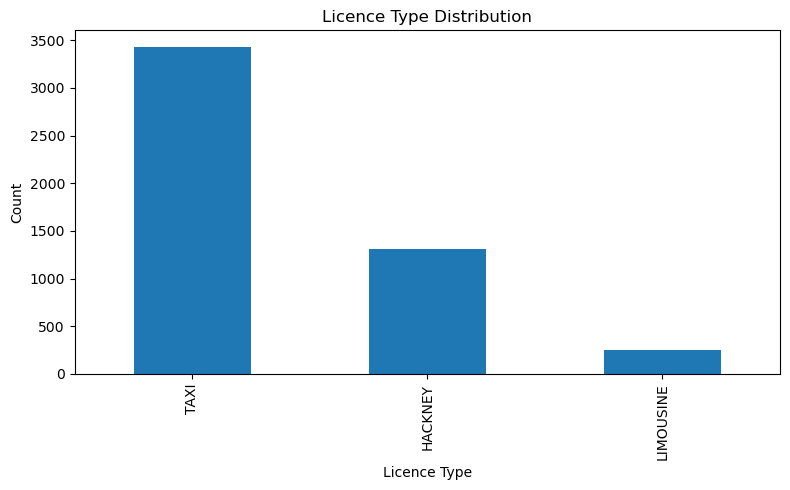

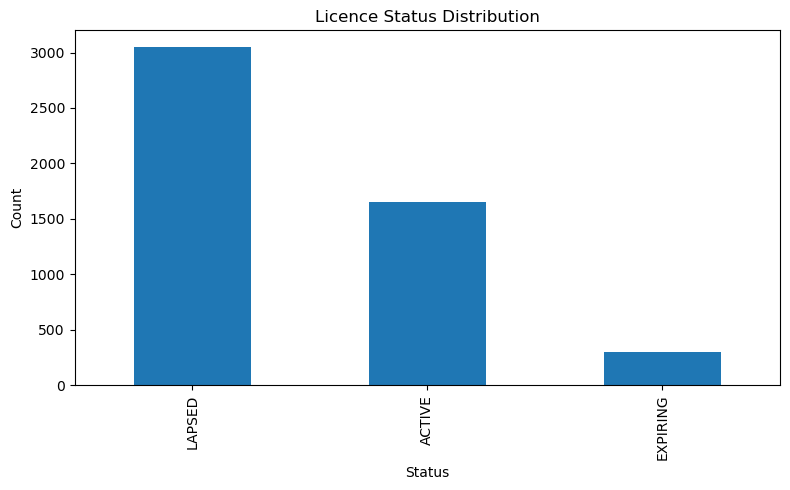

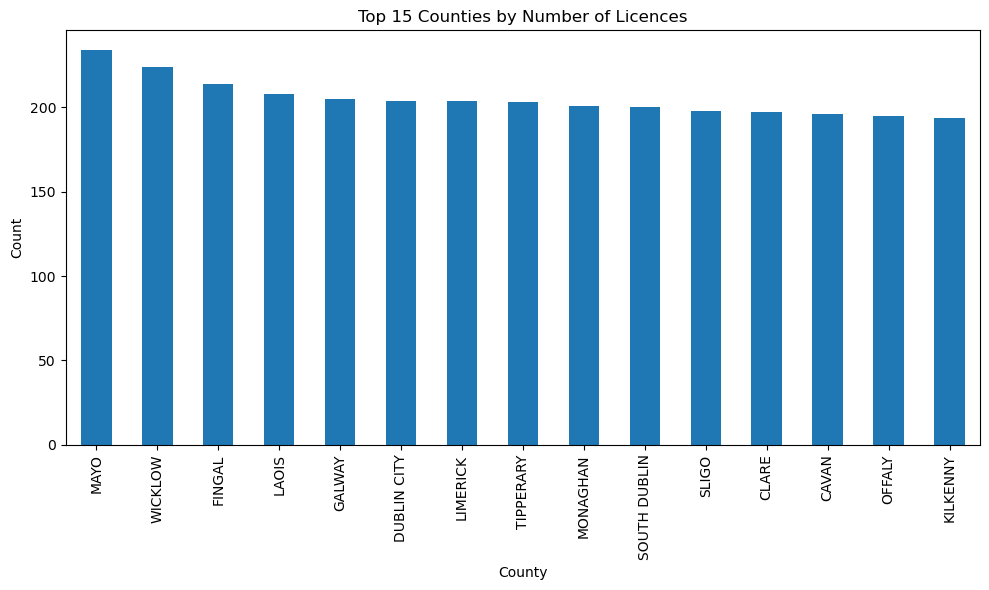

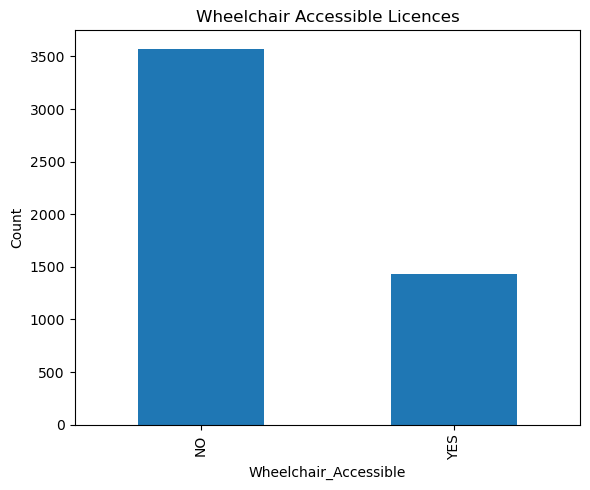

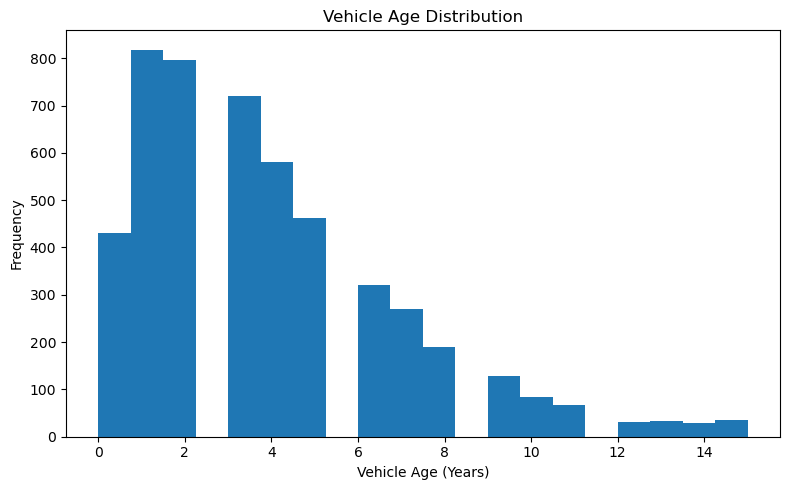

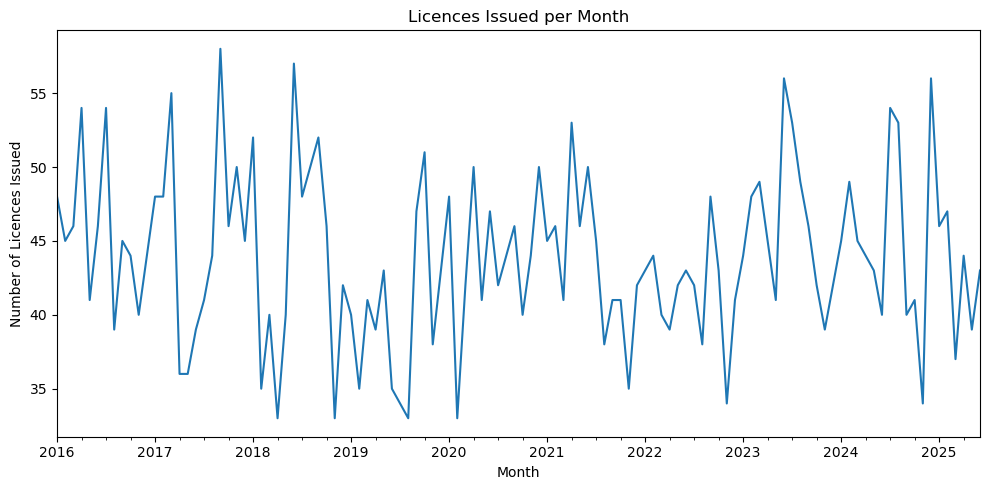

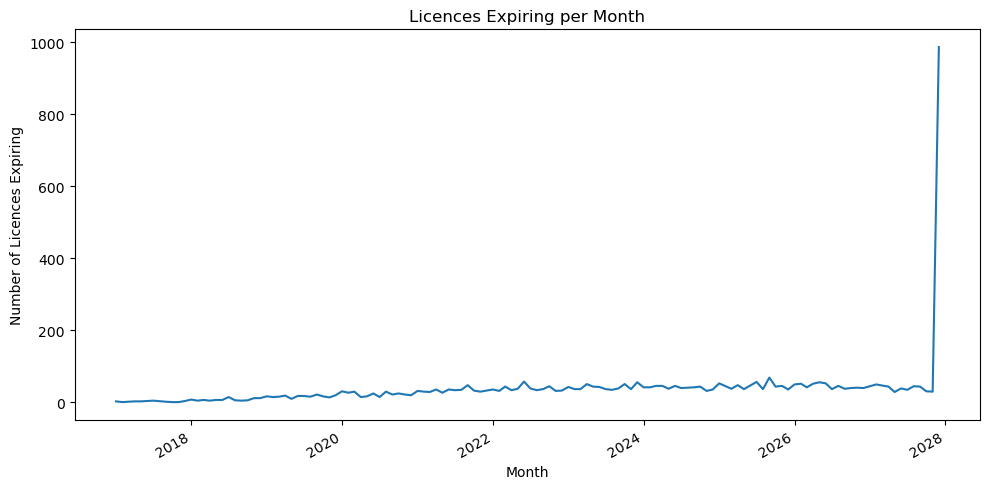

In [13]:
# ------------------------------------------------------------
# 4) LICENSING EDA (trends + distribution)
# ------------------------------------------------------------

# Licensing is core to the project objective (volumes, types, regions, status).
# These charts will directly feed dashboard sections like "Licensing Trends".

# 4.1 Licence type distribution

plt.figure(figsize=(8, 5))
licences["Licence_Type"].value_counts().plot(kind="bar")
plt.title("Licence Type Distribution")
plt.xlabel("Licence Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.2 Licence status distribution
plt.figure(figsize=(8, 5))
licences["Status"].value_counts().plot(kind="bar")
plt.title("Licence Status Distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.3 Licences by County (top 15)
plt.figure(figsize=(10, 6))
licences["County"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Counties by Number of Licences")
plt.xlabel("County")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.4 Wheelchair accessible share
plt.figure(figsize=(6, 5))
licences["Wheelchair_Accessible"].value_counts().plot(kind="bar")
plt.title("Wheelchair Accessible Licences")
plt.xlabel("Wheelchair_Accessible")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.5 Vehicle age distribution (histogram)
plt.figure(figsize=(8, 5))
licences["Vehicle_Age"].plot(kind="hist", bins=20)
plt.title("Vehicle Age Distribution")
plt.xlabel("Vehicle Age (Years)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4.6 Licence issue trend over time (monthly)

# Grouping by month allows trend analysis and supports forecasting later.
licences_issue_monthly = (
    licences.dropna(subset=["Issue_Date"])
           .assign(Issue_Month=lambda d: d["Issue_Date"].dt.to_period("M").dt.to_timestamp())
           .groupby("Issue_Month")["Licence_ID"]
           .count()
)

plt.figure(figsize=(10, 5))
licences_issue_monthly.plot(kind="line")
plt.title("Licences Issued per Month")
plt.xlabel("Month")
plt.ylabel("Number of Licences Issued")
plt.tight_layout()
plt.show()

# 4.7 Licence expiry trend over time (monthly)
licences_expiry_monthly = (
    licences.dropna(subset=["Expiry_Date"])
           .assign(Expiry_Month=lambda d: d["Expiry_Date"].dt.to_period("M").dt.to_timestamp())
           .groupby("Expiry_Month")["Licence_ID"]
           .count()
)

plt.figure(figsize=(10, 5))
licences_expiry_monthly.plot(kind="line")
plt.title("Licences Expiring per Month")
plt.xlabel("Month")
plt.ylabel("Number of Licences Expiring")
plt.tight_layout()
plt.show()

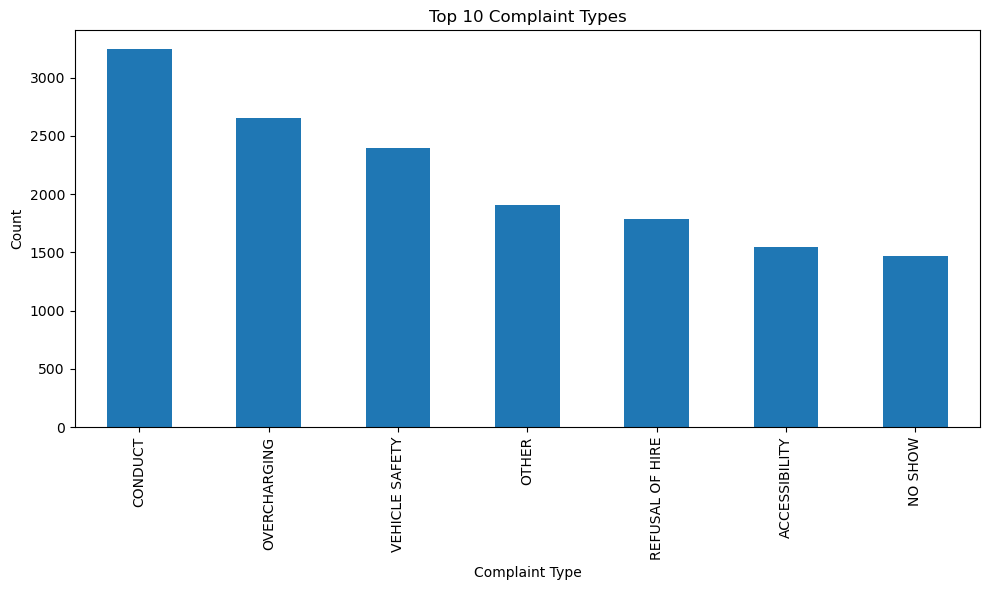

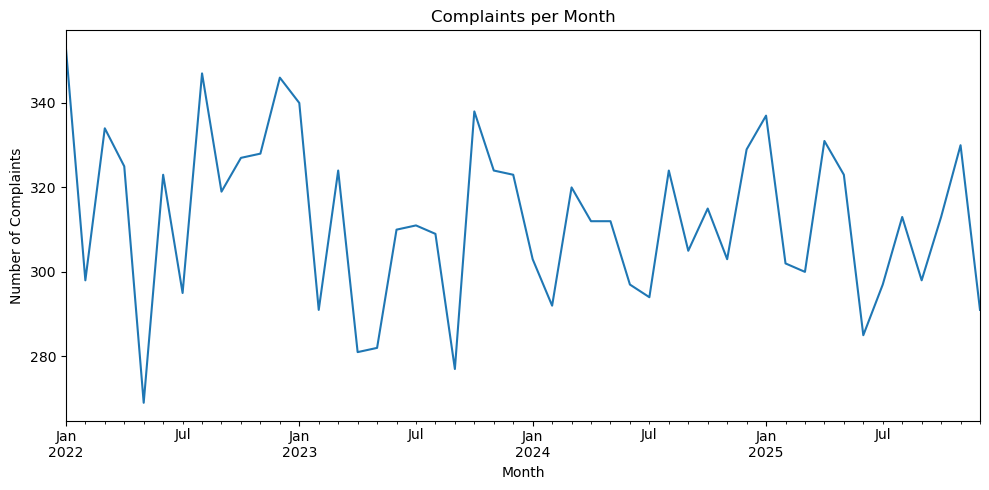

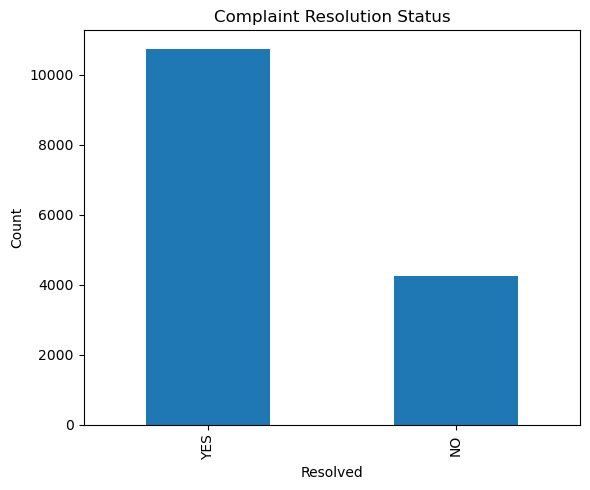

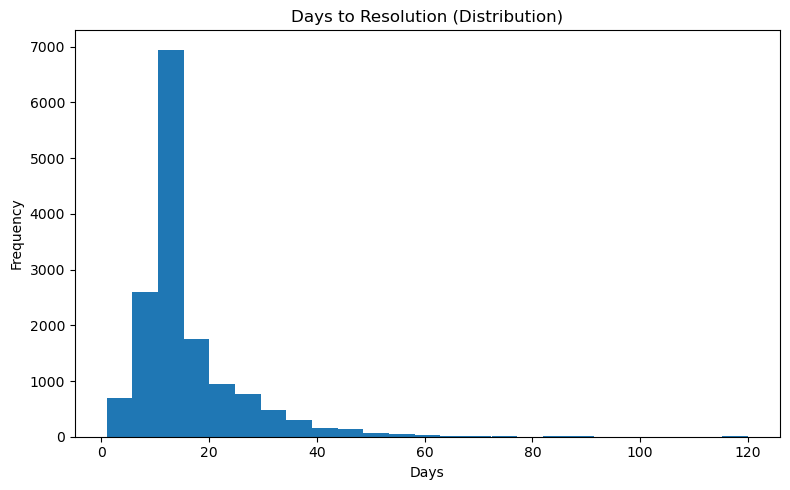

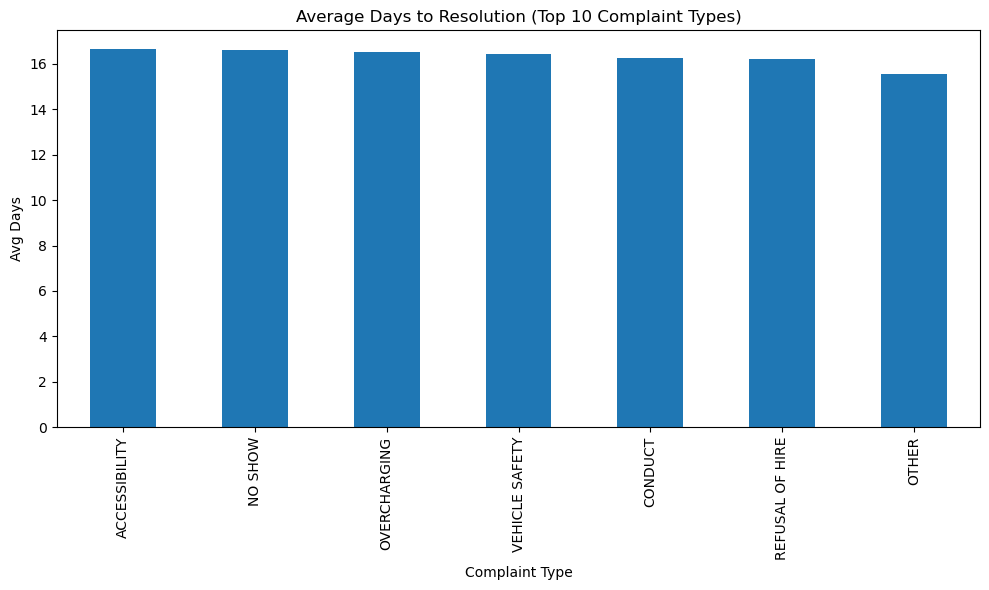

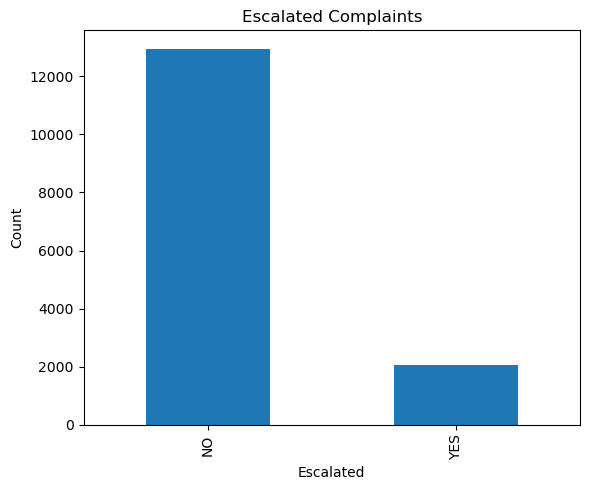

In [5]:
# ------------------------------------------------------------
# 5) COMPLAINTS EDA (types, trends, resolution)
# ------------------------------------------------------------

# Complaints represent consumer feedback and possible risk signals.
# These findings will support dashboard widgets like:
# - Complaint breakdown
# - Resolution performance
# - Escalation monitoring

# 5.1 Top complaint types
plt.figure(figsize=(10, 6))
complaints["Complaint_Type"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Complaint Types")
plt.xlabel("Complaint Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.2 Complaints trend over time (monthly)
complaints_monthly = (
    complaints.dropna(subset=["Date_Received"])
              .assign(Month=lambda d: d["Date_Received"].dt.to_period("M").dt.to_timestamp())
              .groupby("Month")["Complaint_ID"]
              .count()
)

plt.figure(figsize=(10, 5))
complaints_monthly.plot(kind="line")
plt.title("Complaints per Month")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

# 5.3 Resolution rate (Resolved yes/no)
plt.figure(figsize=(6, 5))
complaints["Resolved"].value_counts().plot(kind="bar")
plt.title("Complaint Resolution Status")
plt.xlabel("Resolved")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.4 Days to resolution distribution
plt.figure(figsize=(8, 5))
complaints["Days_To_Resolution"].plot(kind="hist", bins=25)
plt.title("Days to Resolution (Distribution)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5.5 Average days to resolution by complaint type (top 10 by volume)

# This helps identify which complaint categories take the longest to resolve.
top_types = complaints["Complaint_Type"].value_counts().head(10).index
avg_days_by_type = (
    complaints[complaints["Complaint_Type"].isin(top_types)]
    .groupby("Complaint_Type")["Days_To_Resolution"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
avg_days_by_type.plot(kind="bar")
plt.title("Average Days to Resolution (Top 10 Complaint Types)")
plt.xlabel("Complaint Type")
plt.ylabel("Avg Days")
plt.tight_layout()
plt.show()

# 5.6 Escalation rate
plt.figure(figsize=(6, 5))
complaints["Escalated"].value_counts().plot(kind="bar")
plt.title("Escalated Complaints")
plt.xlabel("Escalated")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


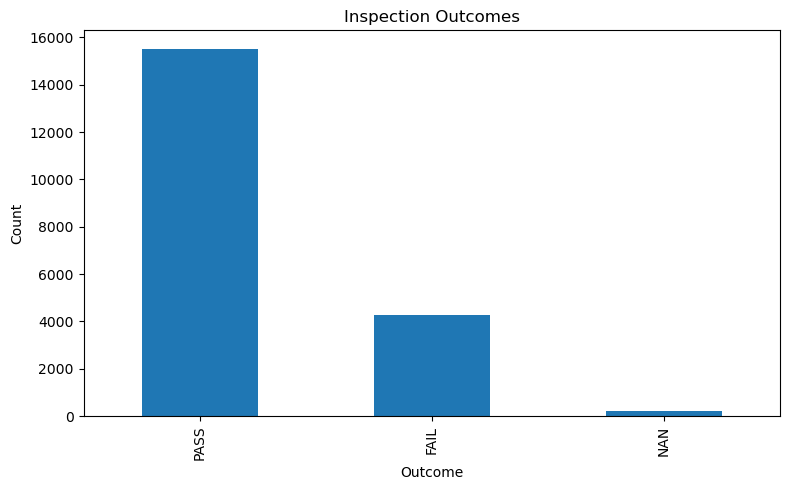

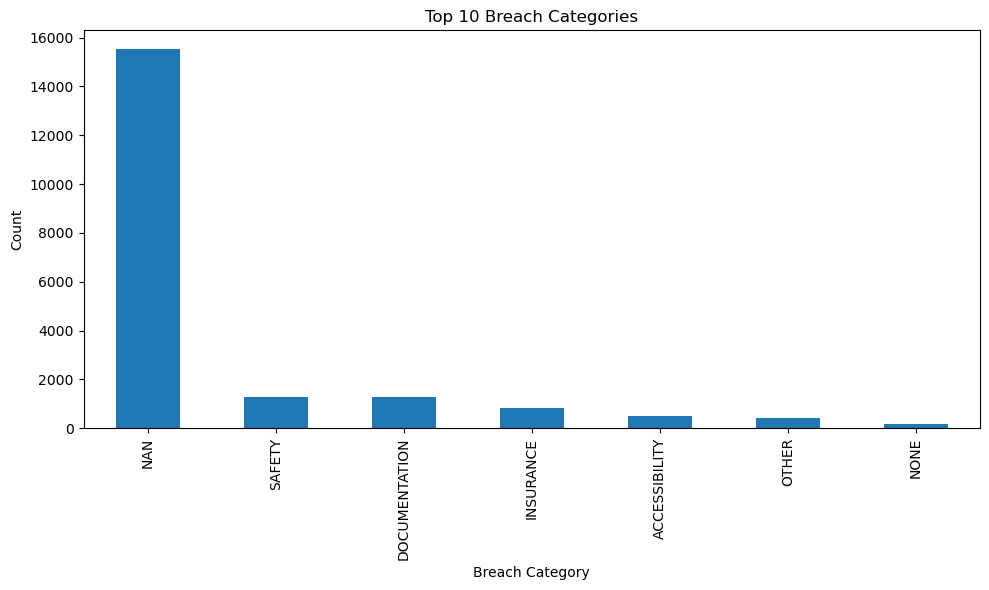

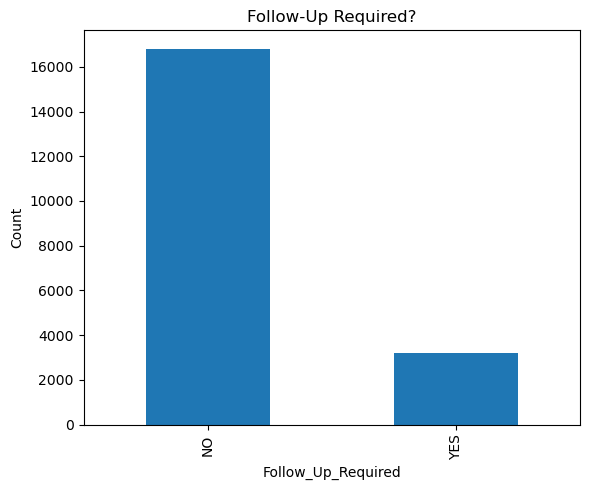

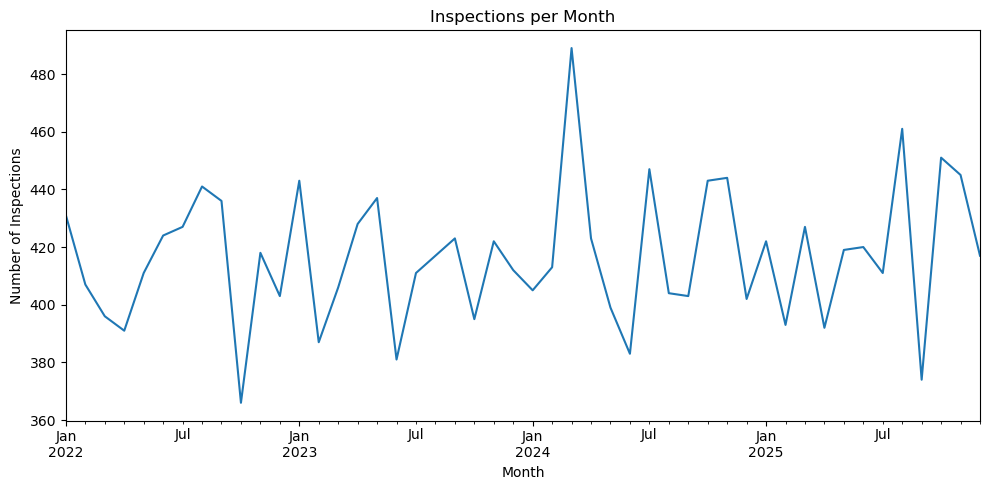

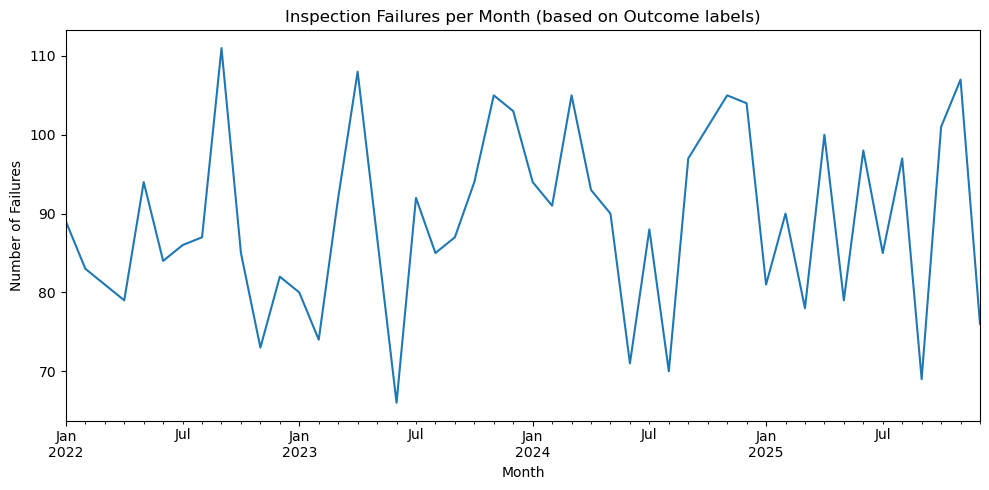

In [6]:
# ------------------------------------------------------------
# 6) INSPECTIONS EDA (outcomes, breaches, follow-ups)
# ------------------------------------------------------------

# Inspections reflect compliance monitoring.
# Results will support dashboard charts like:
# - pass/fail trends
# - breach categories
# - follow-up workload

# 6.1 Inspection outcome distribution
plt.figure(figsize=(8, 5))
inspections["Outcome"].value_counts().plot(kind="bar")
plt.title("Inspection Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6.2 Breach categories (top 10)
plt.figure(figsize=(10, 6))
inspections["Breach_Category"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Breach Categories")
plt.xlabel("Breach Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6.3 Follow-up required distribution
plt.figure(figsize=(6, 5))
inspections["Follow_Up_Required"].value_counts().plot(kind="bar")
plt.title("Follow-Up Required?")
plt.xlabel("Follow_Up_Required")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6.4 Inspections trend over time (monthly)
inspections_monthly = (
    inspections.dropna(subset=["Inspection_Date"])
              .assign(Month=lambda d: d["Inspection_Date"].dt.to_period("M").dt.to_timestamp())
              .groupby("Month")["Inspection_ID"]
              .count()
)

plt.figure(figsize=(10, 5))
inspections_monthly.plot(kind="line")
plt.title("Inspections per Month")
plt.xlabel("Month")
plt.ylabel("Number of Inspections")
plt.tight_layout()
plt.show()

# 6.5 Failures over time (monthly)

# I define a "failure" based on the Outcome field containing typical failure labels.
# This is a simple student-friendly approach and can be refined if needed.
failure_labels = {"FAIL", "FAILED", "NON-COMPLIANT", "NON COMPLIANT"}

inspections_fail_monthly = (
    inspections.dropna(subset=["Inspection_Date"])
              .assign(Month=lambda d: d["Inspection_Date"].dt.to_period("M").dt.to_timestamp())
              .assign(Is_Fail=lambda d: d["Outcome"].astype(str).str.upper().isin(failure_labels))
              .groupby("Month")["Is_Fail"]
              .sum()
)

plt.figure(figsize=(10, 5))
inspections_fail_monthly.plot(kind="line")
plt.title("Inspection Failures per Month (based on Outcome labels)")
plt.xlabel("Month")
plt.ylabel("Number of Failures")
plt.tight_layout()
plt.show()

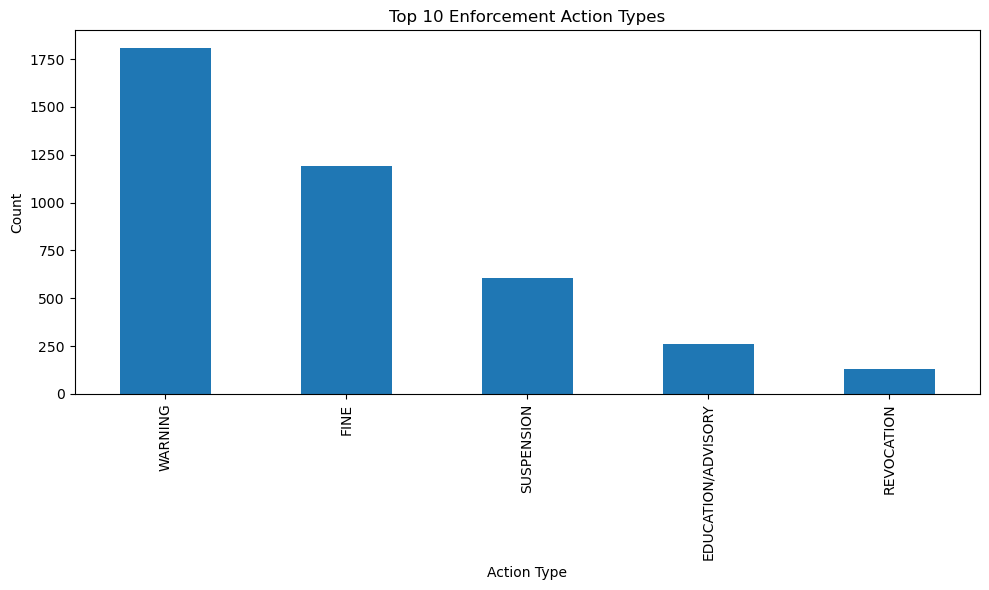

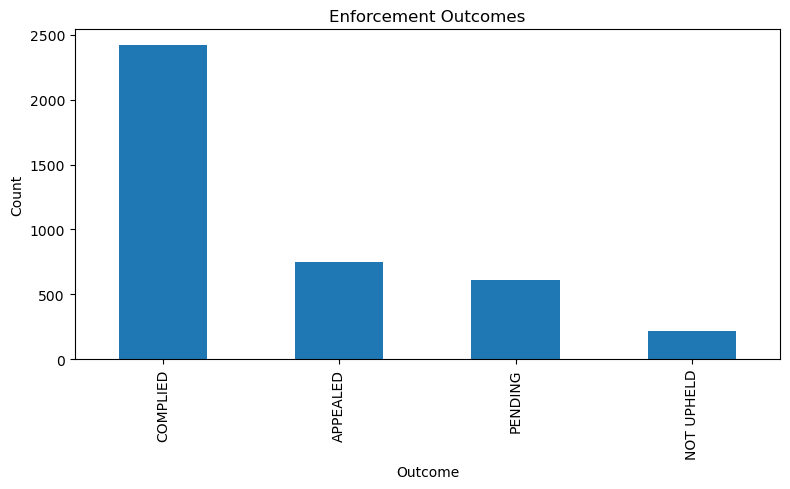

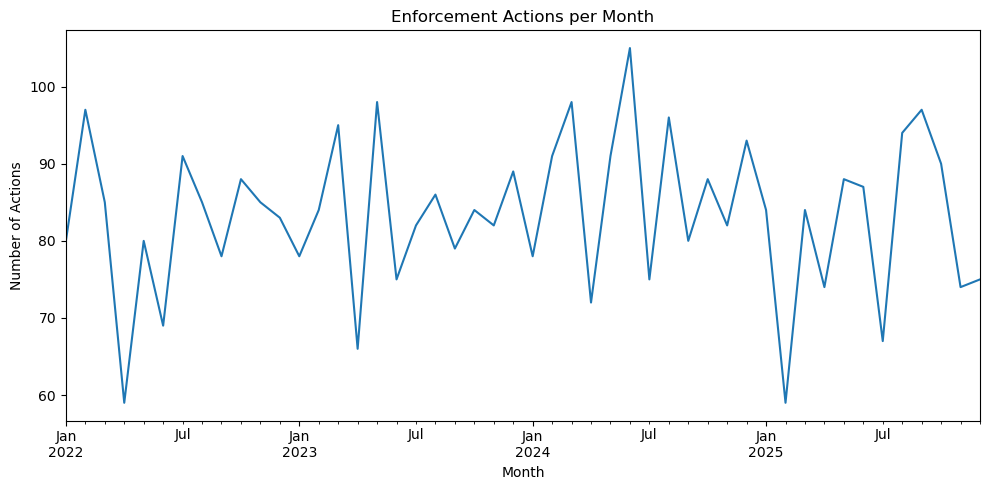

In [7]:
# ------------------------------------------------------------
# 7) ENFORCEMENT EDA (action types, outcomes, trends)
# ------------------------------------------------------------

# Enforcement actions help identify regulatory pressure and non-compliance response.
# These results support the dashboard's "Enforcement Insights" section.

# 7.1 Action type distribution
plt.figure(figsize=(10, 6))
enforcement["Action_Type"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Enforcement Action Types")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7.2 Outcome distribution
plt.figure(figsize=(8, 5))
enforcement["Outcome"].value_counts().plot(kind="bar")
plt.title("Enforcement Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7.3 Enforcement actions over time (monthly)
enforcement_monthly = (
    enforcement.dropna(subset=["Action_Date"])
              .assign(Month=lambda d: d["Action_Date"].dt.to_period("M").dt.to_timestamp())
              .groupby("Month")["Enforcement_ID"]
              .count()
)

plt.figure(figsize=(10, 5))
enforcement_monthly.plot(kind="line")
plt.title("Enforcement Actions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Actions")
plt.tight_layout()
plt.show()


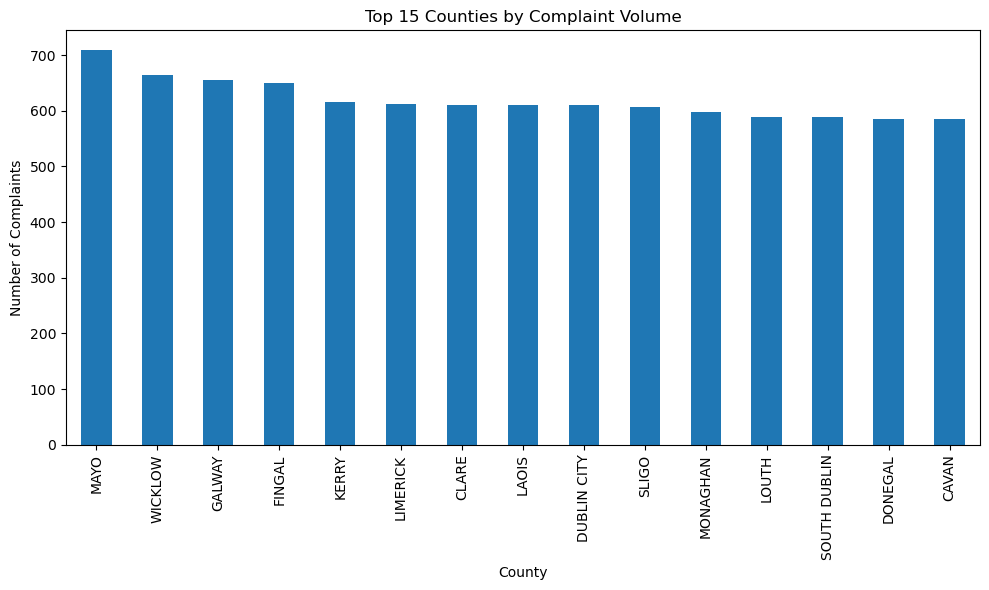


--- County inspection summary (top 10 by failure rate) ---
              Inspections  Failures  Failure_Rate
County                                           
WEXFORD               767       184      0.239896
MEATH                 714       171      0.239496
DONEGAL               723       166      0.229599
SOUTH DUBLIN          824       189      0.229369
KILKENNY              830       190      0.228916
OFFALY                744       170      0.228495
TIPPERARY             871       197      0.226177
LOUTH                 771       174      0.225681
DUBLIN CITY           805       178      0.221118
WATERFORD             711       157      0.220816


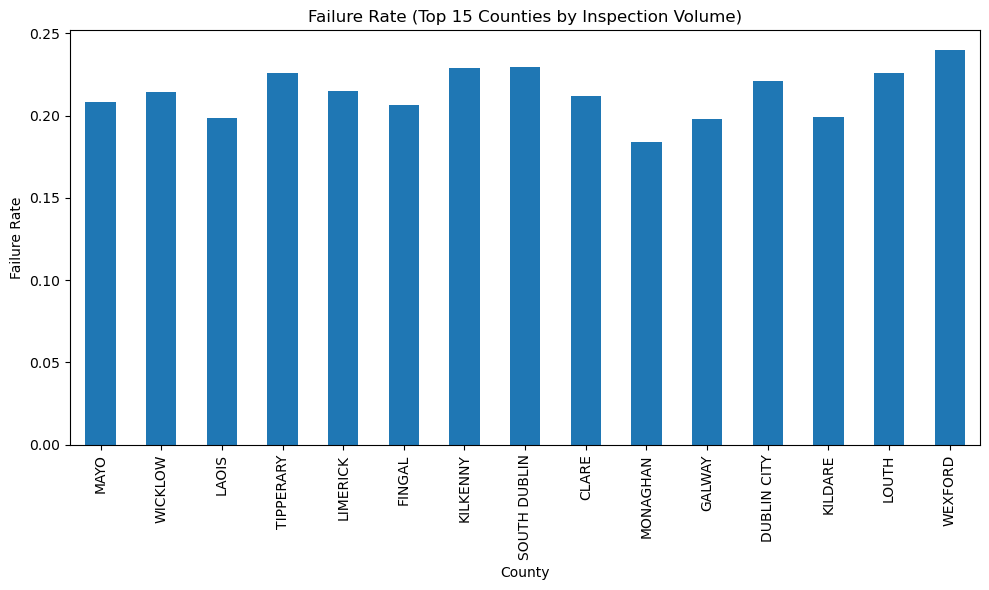

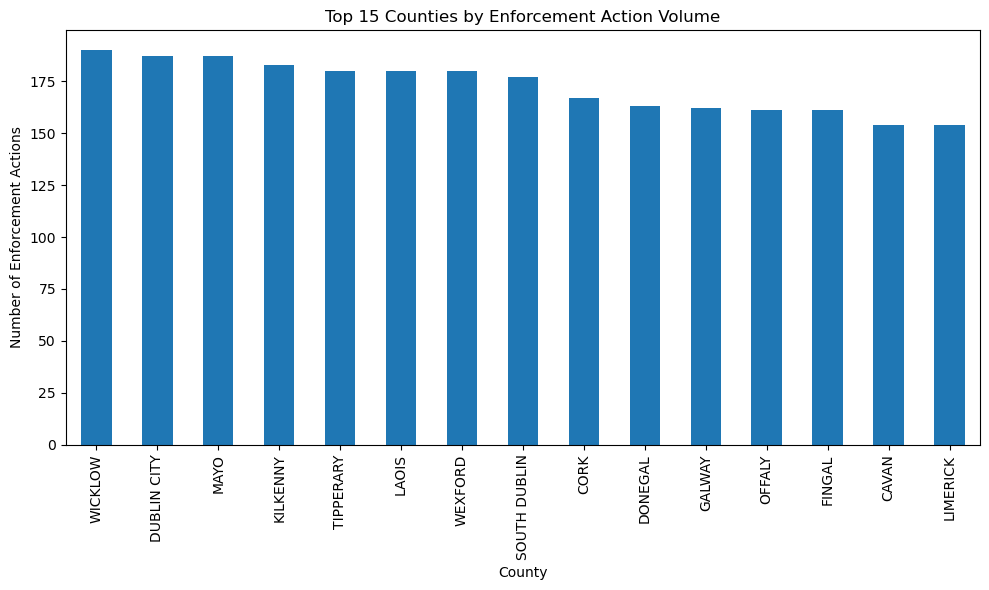

In [8]:
# ------------------------------------------------------------
# 8) CROSS-DATASET EDA (joins to link risk signals to geography)
# ------------------------------------------------------------

# To support the project objective (identify high-risk areas/operators),
# I link operational data (complaints/inspections/enforcement) to the
# licensing table (which contains County and licence characteristics).
#
# This allows analysis like:
# - complaints by county
# - inspection failures by county
# - enforcement actions by county

# 8.1 Complaints by County (join complaints -> licences via Licence_ID)
complaints_with_county = complaints.merge(
    licences[["Licence_ID", "County", "Licence_Type", "Status"]],
    on="Licence_ID",
    how="left"
)

plt.figure(figsize=(10, 6))
complaints_with_county["County"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Counties by Complaint Volume")
plt.xlabel("County")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

# 8.2 Inspections by County + failure rate estimate
inspections_with_county = inspections.merge(
    licences[["Licence_ID", "County"]],
    on="Licence_ID",
    how="left"
)

inspections_with_county["Is_Fail"] = inspections_with_county["Outcome"].astype(str).str.upper().isin(failure_labels)

county_inspection_summary = (
    inspections_with_county
    .groupby("County")
    .agg(
        Inspections=("Inspection_ID", "count"),
        Failures=("Is_Fail", "sum")
    )
    .assign(Failure_Rate=lambda d: d["Failures"] / d["Inspections"])
    .sort_values("Failure_Rate", ascending=False)
)

print("\n--- County inspection summary (top 10 by failure rate) ---")
print(county_inspection_summary.head(10))

plt.figure(figsize=(10, 6))
county_inspection_summary.sort_values("Inspections", ascending=False).head(15)["Failure_Rate"].plot(kind="bar")
plt.title("Failure Rate (Top 15 Counties by Inspection Volume)")
plt.xlabel("County")
plt.ylabel("Failure Rate")
plt.tight_layout()
plt.show()

# 8.3 Enforcement actions by County
enforcement_with_county = enforcement.merge(
    licences[["Licence_ID", "County"]],
    on="Licence_ID",
    how="left"
)

plt.figure(figsize=(10, 6))
enforcement_with_county["County"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Counties by Enforcement Action Volume")
plt.xlabel("County")
plt.ylabel("Number of Enforcement Actions")
plt.tight_layout()
plt.show()


--- Monthly national KPI summary (first 5 rows) ---
            Inspections  Failures  Follow_Ups  Complaints  Escalations
Month                                                                 
2022-01-01          430        89          67         350           51
2022-02-01          406        83          64         297           39
2022-03-01          391        81          58         330           52
2022-04-01          387        78          53         322           48
2022-05-01          405        93          64         266           30


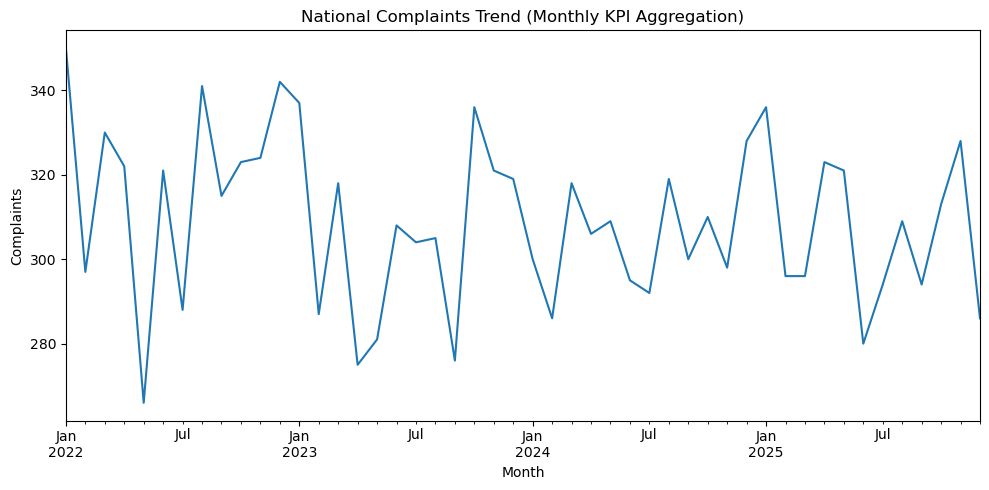

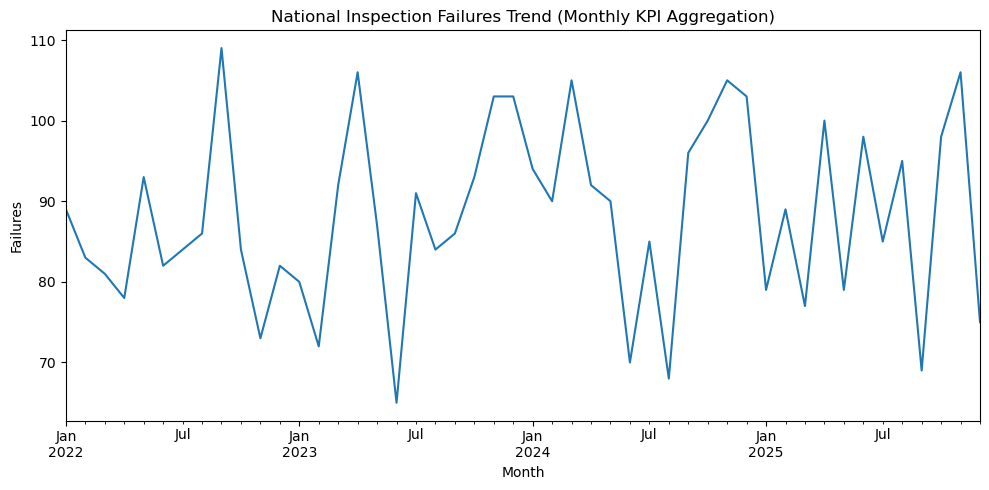


--- Correlation Matrix (National Monthly KPIs) ---
             Complaints  Failures  Inspections  Escalations
Complaints     1.000000  0.018209     0.034314     0.531879
Failures       0.018209  1.000000     0.490090    -0.182039
Inspections    0.034314  0.490090     1.000000    -0.121361
Escalations    0.531879 -0.182039    -0.121361     1.000000


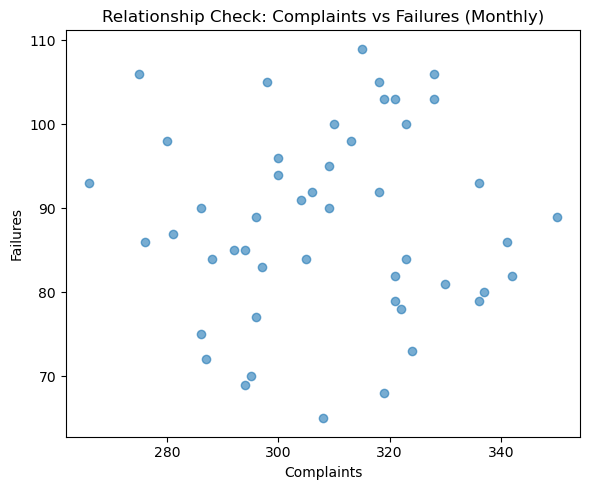

In [9]:
# ------------------------------------------------------------
# 9) MONTHLY KPI EDA (useful for dashboard KPIs + ML forecasting)
# ------------------------------------------------------------

# Monthly KPI data is already aggregated, which makes it useful for:
# - KPI cards in the dashboard
# - forecasting modelling (later phase)

# 9.1 National trend (sum across counties per month)

monthly_national = (
    monthly_kpis.dropna(subset=["Month"])
               .groupby("Month")[["Inspections", "Failures", "Follow_Ups", "Complaints", "Escalations"]]
               .sum()
               .sort_index()
)

print("\n--- Monthly national KPI summary (first 5 rows) ---")
print(monthly_national.head())

plt.figure(figsize=(10, 5))
monthly_national["Complaints"].plot(kind="line")
plt.title("National Complaints Trend (Monthly KPI Aggregation)")
plt.xlabel("Month")
plt.ylabel("Complaints")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
monthly_national["Failures"].plot(kind="line")
plt.title("National Inspection Failures Trend (Monthly KPI Aggregation)")
plt.xlabel("Month")
plt.ylabel("Failures")
plt.tight_layout()
plt.show()

# 9.2 Relationship check: complaints vs failures (simple correlation)

# This is a basic exploratory relationship check to inform later modelling.
corr = monthly_national[["Complaints", "Failures", "Inspections", "Escalations"]].corr()
print("\n--- Correlation Matrix (National Monthly KPIs) ---")
print(corr)

# Scatter plot: Complaints vs Failures
plt.figure(figsize=(6, 5))
plt.scatter(monthly_national["Complaints"], monthly_national["Failures"], alpha=0.6)
plt.title("Relationship Check: Complaints vs Failures (Monthly)")
plt.xlabel("Complaints")
plt.ylabel("Failures")
plt.tight_layout()
plt.show()


In [11]:
# EDA revealed inconsistent encoding in the Wheelchair_Accessible field.
# Values 'Y'/'N' represent the same meaning as 'YES'/'NO'.
# These are standardised to avoid splitting counts across categories.

licences["Wheelchair_Accessible"] = (
    licences["Wheelchair_Accessible"]
    .replace({"Y": "YES", "N": "NO"})
)

# Quick verification
print(licences["Wheelchair_Accessible"].value_counts())

Wheelchair_Accessible
NO     3570
YES    1430
Name: count, dtype: int64


In [12]:
# ------------------------------------------------------------
# 10) OUTPUT: Save joined tables (optional but useful for dashboard)
# ------------------------------------------------------------

# I save merged tables so dashboard development is faster later.
complaints_with_county.to_csv("complaints_with_county.csv", index=False)
inspections_with_county.to_csv("inspections_with_county.csv", index=False)
enforcement_with_county.to_csv("enforcement_with_county.csv", index=False)

print("\nEDA phase complete. Saved merged tables for dashboard use:")
print("- complaints_with_county.csv")
print("- inspections_with_county.csv")
print("- enforcement_with_county.csv")


EDA phase complete. Saved merged tables for dashboard use:
- complaints_with_county.csv
- inspections_with_county.csv
- enforcement_with_county.csv
